# 13 October 2021

## **Latihan Agglomerative Clustering  & DBScan**

- Lakukan EDA untuk memahami dataset.
- Jelaskan mengenai insight yang didapat dari EDA!
<br><br>
- Untuk clustering, drop saja feature 'CustomerID' dan 'Gender', lalu cari kombinasi 2 feature terbaik berdasarkan silhouette score-nya yang selanjutnya akan digunakan untuk clustering.
- Lakukan scaling menggunakan standard scaler, lalu gunakan metode K-Means, Agglomerative clustering, dan DBScan. Cari jumlah cluster paling optimal untuk tiap metode.
<br><br>
- Bandingkan hasil dari ketiga metode yang sudah dicoba, manakah metode yang terbaik? 
- Interpretasikan hasil clustering-nya!

## **Import libraries**

In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, ward, complete, average

import warnings
warnings.filterwarnings('ignore')

## **Load & explore dataset**

In [ ]:
df = pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
# Rename columns
df = df.rename(columns={'Spending Score (1-100)': 'Spending Score',
        'Annual Income (k$)': 'Annual Income'})

In [ ]:
# Drop customerID column
df.drop('CustomerID', axis=1, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Gender          200 non-null    object
 1   Age             200 non-null    int64 
 2   Annual Income   200 non-null    int64 
 3   Spending Score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


In [ ]:
df.describe()

,Age,Annual Income,Spending Score
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [ ]:
df.isna().sum()

Gender            0
Age               0
Annual Income     0
Spending Score    0
dtype: int64

## **EDA**

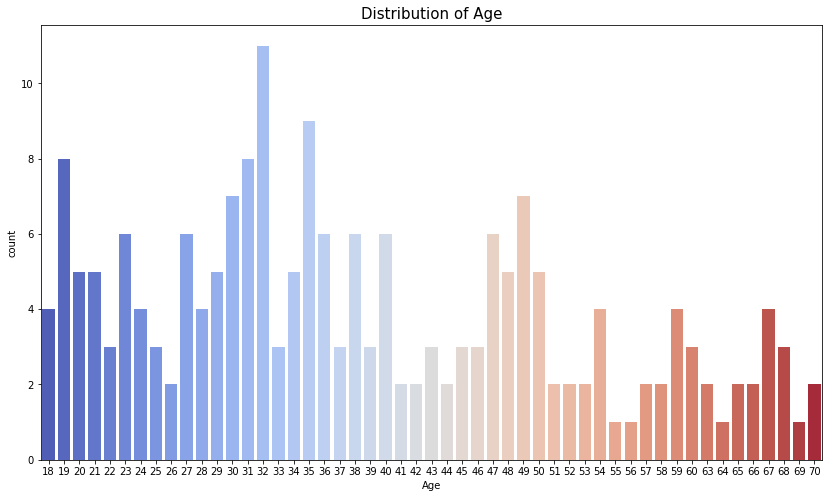

In [ ]:
plt.figure(figsize=(14, 8))
sns.countplot(df['Age'], palette = 'coolwarm')
plt.title('Distribution of Age', fontsize = 15);

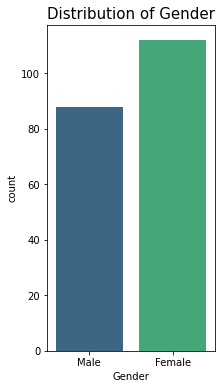

In [ ]:
plt.figure(figsize=(3, 6))
sns.countplot(df['Gender'], palette = 'viridis')
plt.title('Distribution of Gender', fontsize = 15);

In [ ]:
df['Gender'].value_counts()/df.shape[0]*100

Female    56.0
Male      44.0
Name: Gender, dtype: float64

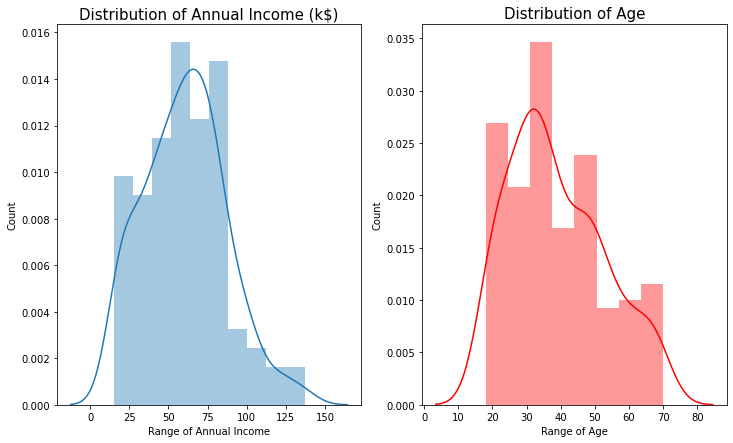

In [ ]:
plt.figure(figsize=(12, 7))

plt.subplot(1, 2, 1)
sns.distplot(df['Annual Income'])
plt.title('Distribution of Annual Income (k$)', fontsize = 15)
plt.xlabel('Range of Annual Income')
plt.ylabel('Count')


plt.subplot(1, 2, 2)
sns.distplot(df['Age'], color = 'red')
plt.title('Distribution of Age', fontsize = 15)
plt.xlabel('Range of Age')
plt.ylabel('Count');

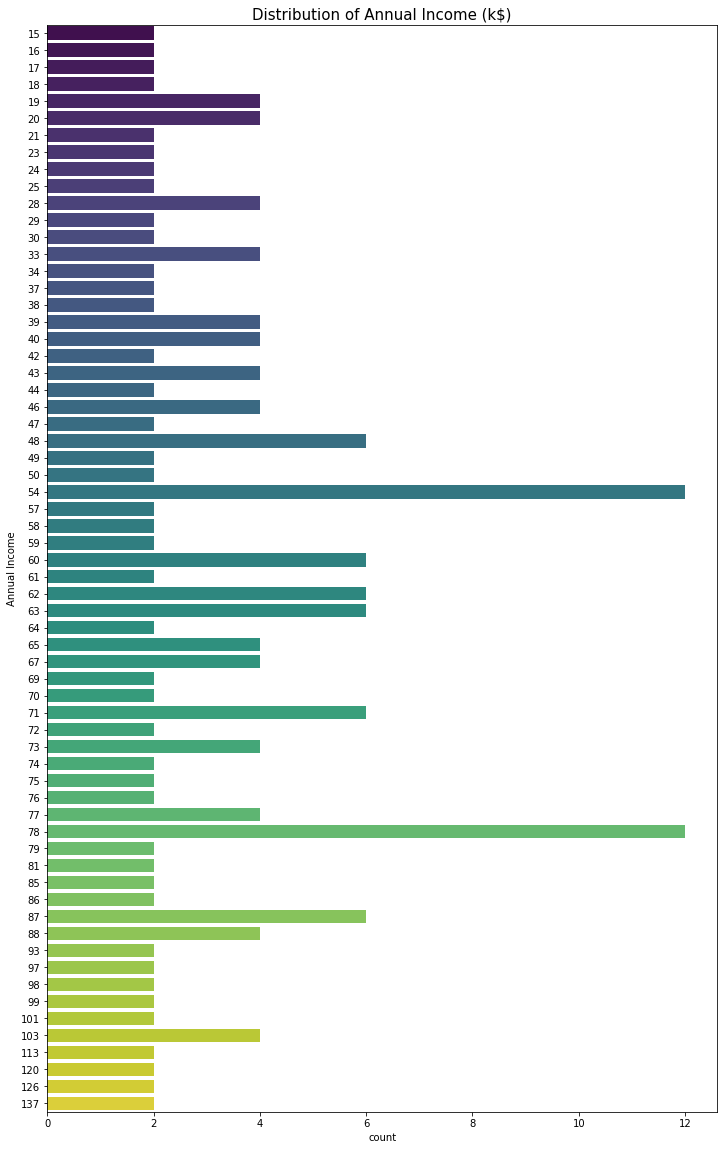

In [ ]:
plt.figure(figsize=(12, 20))
sns.countplot(y='Annual Income', data=df, palette='viridis')
plt.title('Distribution of Annual Income (k$)', fontsize = 15);

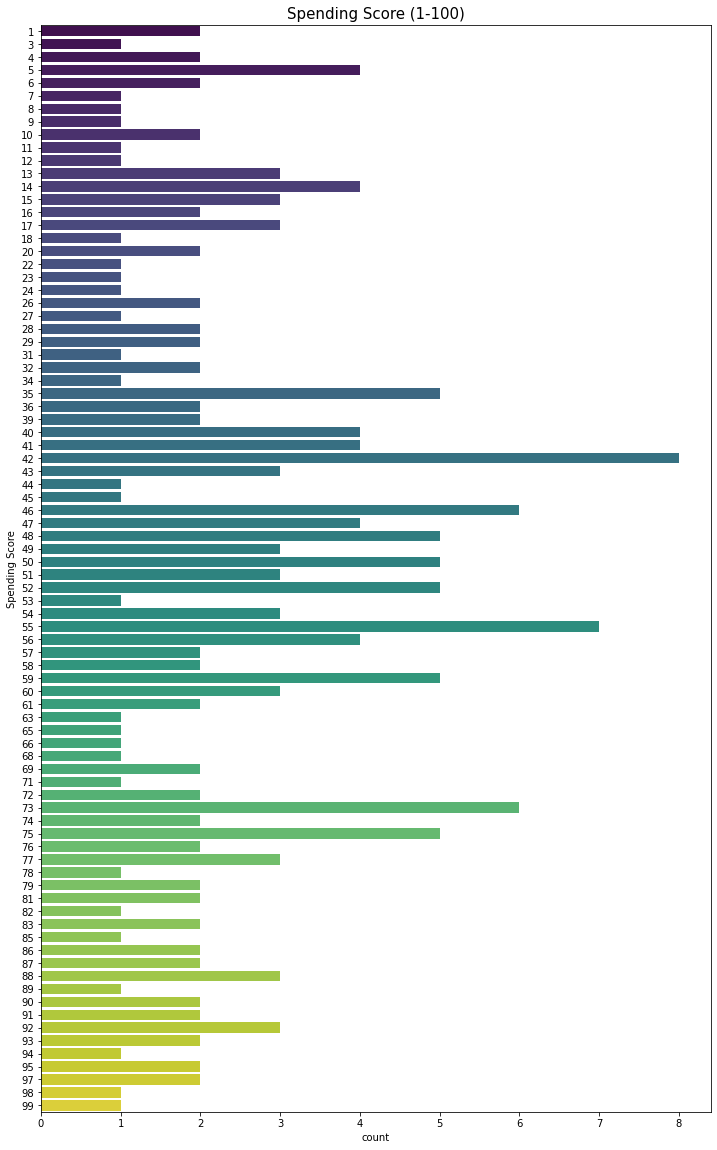

In [ ]:
plt.figure(figsize=(12, 20))
sns.countplot(y='Spending Score', data=df, palette='viridis')
plt.title('Spending Score (1-100)', fontsize = 15);

### **Age vs Annual Income**

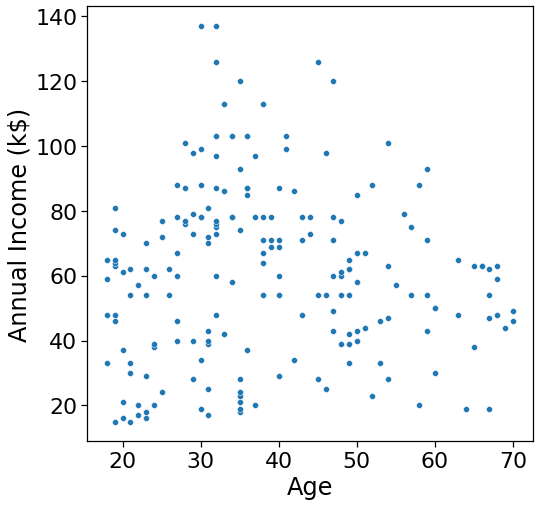

In [ ]:
plt.figure(figsize = (8, 8))
sns.set_context(context = 'notebook', font_scale=2)
sns.scatterplot(
    x = 'Age', 
    y = 'Annual Income', 
    data = df)

plt.xlabel('Age')
plt.ylabel('Annual Income (k$)');

### **Age vs Spending Score**

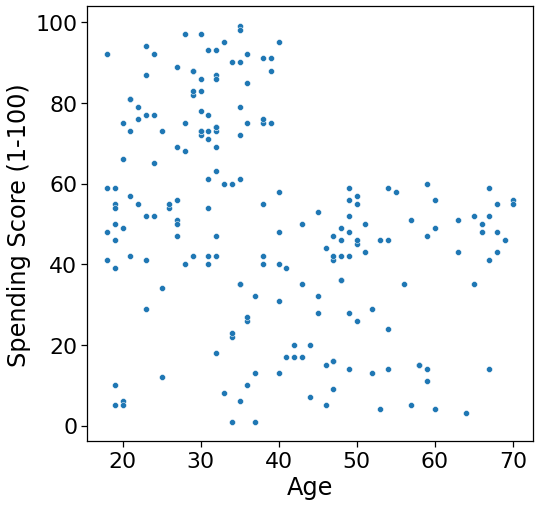

In [ ]:
plt.figure(figsize = (8, 8))
sns.set_context(context = 'notebook', font_scale=2)
sns.scatterplot(
    x = 'Age', 
    y = 'Spending Score', 
    data = df)

plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)');

### **Annual Income vs Spending Score**

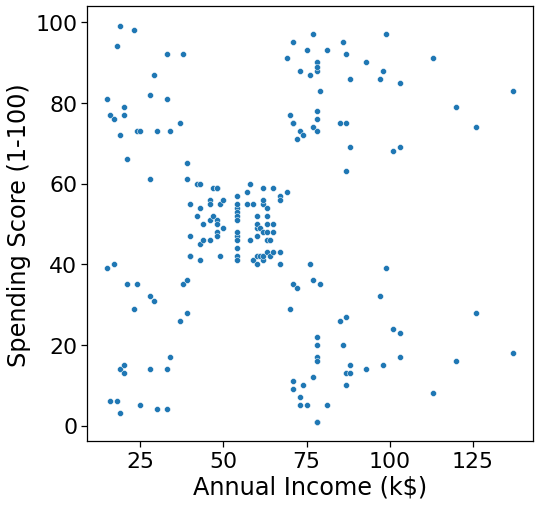

In [ ]:
plt.figure(figsize = (8, 8))
sns.set_context(context = 'notebook', font_scale=2)
sns.scatterplot(
    x = 'Annual Income', 
    y = 'Spending Score', 
    data = df)

plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)');

## **Clustering**

Untuk tujuan clustering dengan metode yang akan digunakan, feature 'Gender' akan didrop karena merupakan categorical feature.

In [ ]:
df = df.drop(columns='Gender', axis=1)
df.head()

,Age,Annual Income,Spending Score
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


## **Finding the best features combination**

## **Scaling**

In [ ]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=['Age', 'Annual Income', 'Spending Score'])
df_scaled

,Age,Annual Income,Spending Score
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980
...,...,...,...
195,-0.276302,2.268791,1.118061
196,0.441365,2.497807,-0.861839
197,-0.491602,2.497807,0.923953
198,-0.491602,2.917671,-1.250054


In [ ]:
import itertools

silhouette = []
score = 0
this_list = ['Age', 'Annual Income', 'Spending Score']

for i in itertools.combinations(this_list, 2):
    kmeans = KMeans(n_clusters=2, random_state=0)
    kmeans.fit(df_scaled)
    labels = kmeans.labels_

    sil = silhouette_score(df_scaled, labels, metric = 'euclidean', random_state=0)
    silhouette.append(sil)

    if score < sil:
        best_combination = i
        score = sil

print(best_combination)
print(score)

('Age', 'Annual Income')
0.33547192894004574


In [ ]:
X = df_scaled[['Annual Income', 'Spending Score']]
X2 = df_scaled[['Age', 'Spending Score']]
X3 = df_scaled[['Age', 'Annual Income']]

cluster_list = [X, X2, X3]

for i in cluster_list:
    kmeans = KMeans(n_clusters=2, random_state=0)
    kmeans.fit(i)
    labels = kmeans.labels_
    print('Silhoutte score:', silhouette_score(i, labels, metric = 'euclidean', random_state=0))
    kmeans.labels_ = 'cluster', i

Silhoutte score: 0.29512063001659344
Silhoutte score: 0.4721271643062346
Silhoutte score: 0.3706886243538429


Karena nilai silhouette score antara 'Age' dan 'Spending Score' paling tinggi, maka untuk proses clustering selanjutnya, hanya akan digunakan 2 feature ini.

In [ ]:
X = df.drop(columns='Annual Income', axis=1)

In [ ]:
X_scaled = df_scaled.drop(columns='Annual Income', axis=1)
X_scaled.head()

,Age,Spending Score
0,-1.424569,-0.434801
1,-1.281035,1.195704
2,-1.352802,-1.715913
3,-1.137502,1.040418
4,-0.563369,-0.395980


## **K-Means**

### **Elbow method**

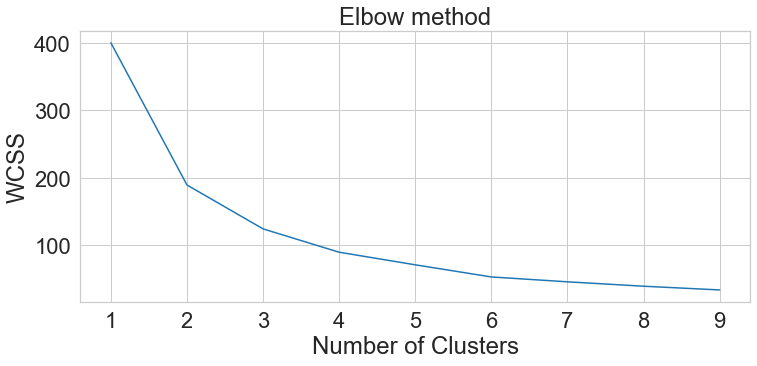

In [ ]:
kmeans_models = [KMeans(n_clusters=k, random_state=0).fit(X_scaled) for k in range (1, 10)]
inertia = [model.inertia_ for model in kmeans_models]

sns.set_style(style='whitegrid')
plt.figure(figsize=(12, 5))
plt.plot(range(1, 10), inertia)
plt.title('Elbow method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS');

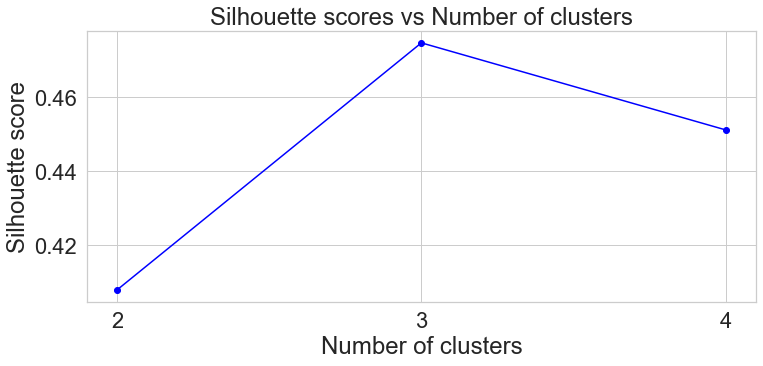

In [ ]:
silhoutte_scores = [silhouette_score(X, model.labels_) for model in kmeans_models[2:5]]

plt.figure(figsize=(12, 5))
plt.plot(range(2, 5), silhoutte_scores, 'bo-')
plt.xticks([2, 3, 4])
plt.title('Silhouette scores vs Number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score');

### **Silhouette method**

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X_scaled)

KMeans(n_clusters=2, random_state=0)

In [ ]:
labels = kmeans.labels_
silhouette_score(X_scaled, labels, metric = 'euclidean', random_state=0)

0.4721271643062346

In [ ]:
silhouette_scores = []
number_of_cluster = range(2, 11)

for i in number_of_cluster:
  kmeans = KMeans(n_clusters=i, random_state=0)
  kmeans.fit(X_scaled)

  labels = kmeans.labels_
  silhouette_scores.append(silhouette_score(X_scaled, labels, metric = 'euclidean', random_state=0))

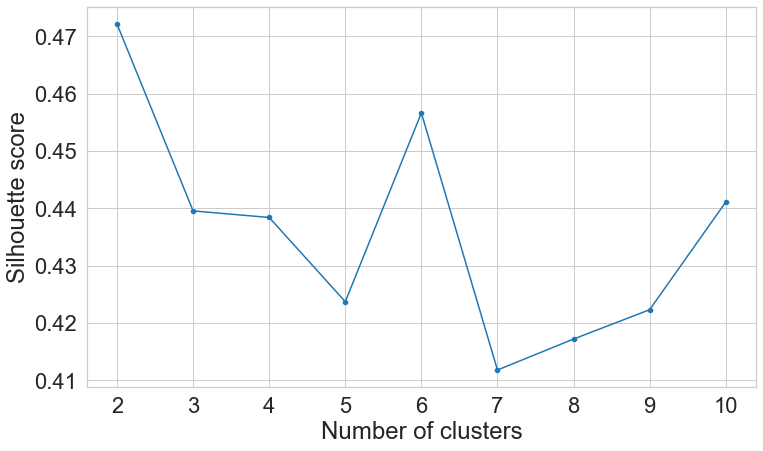

In [ ]:
plt.figure(figsize=(12,7))

sns.lineplot(number_of_cluster, silhouette_scores)
sns.scatterplot(number_of_cluster, silhouette_scores)

plt.xticks(number_of_cluster)

plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score');

### **Interpretation**

Silhouette score tertinggi didapat dengan jumlah cluster = 2.

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X_scaled)

KMeans(n_clusters=2, random_state=0)

In [ ]:
df['clusters'] = kmeans.labels_
df

,Age,Annual Income,Spending Score,clusters
0,19,15,39,1
1,21,15,81,1
2,20,16,6,0
3,23,16,77,1
4,31,17,40,1
...,...,...,...,...
195,35,120,79,1
196,45,126,28,0
197,32,126,74,1
198,32,137,18,0


In [ ]:
print('Silhouette score K-Means:', silhouette_score(X_scaled, kmeans.labels_))

Silhouette score K-Means: 0.4721271643062346


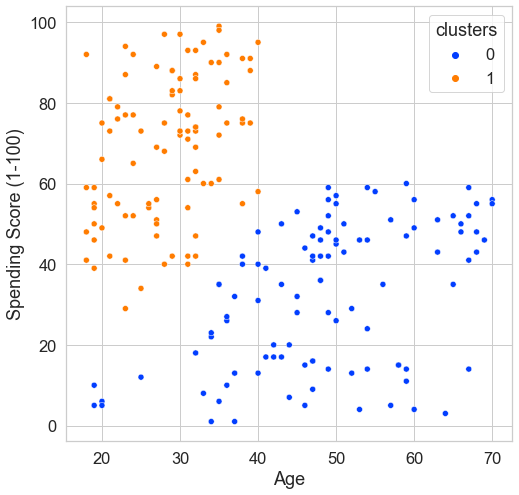

In [ ]:
# Plotting the result
plt.figure(figsize = (8, 8) )
sns.set_context(context = 'notebook', font_scale=1.5)
sns.scatterplot(
    x = 'Age', 
    y = 'Spending Score', 
    hue = 'clusters',
    data = df,
    palette='bright')

plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)');

## **Agglomerative clustering**

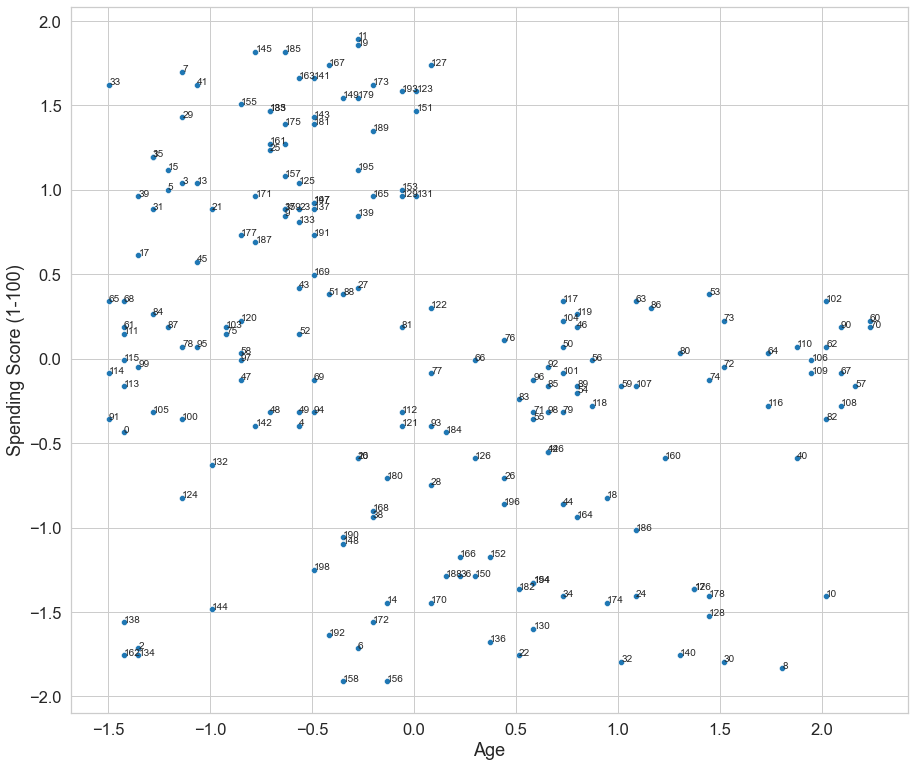

In [ ]:
plt.figure(figsize=(15, 13))
sns.scatterplot(x='Age', y='Spending Score', data=X_scaled)

plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)')

for i,txt in enumerate(range(0,X_scaled.shape[0]-1)):
    plt.annotate(txt,(X_scaled['Age'][i], X_scaled['Spending Score'][i]), fontsize=10)

### **Ward**

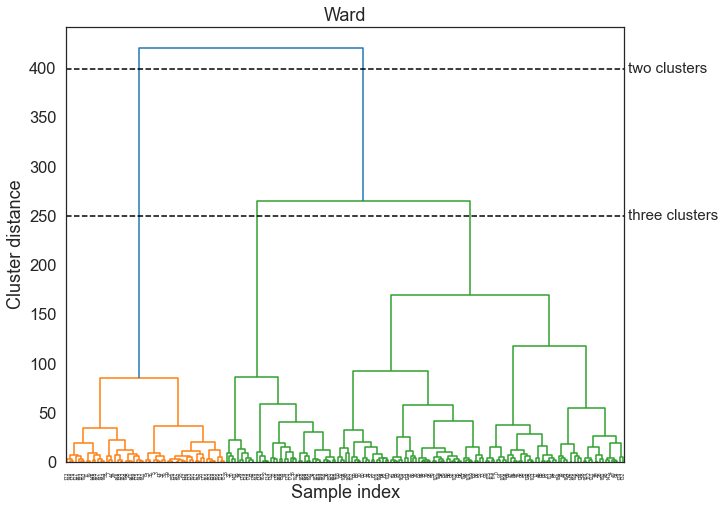

In [ ]:
linkage_array = ward(X)

plt.figure(figsize = (10, 8))
sns.set_style(style='white')

dendrogram(linkage_array, 25)
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [399, 399], '--', c='k')
ax.plot(bounds, [250, 250], '--', c='k')
ax.text(bounds[1], 399, ' two clusters', va='center', fontdict={'size': 15})
ax.text(bounds[1], 250, ' three clusters', va='center', fontdict={'size': 15})
plt.title('Ward')
plt.xlabel('Sample index')
plt.ylabel('Cluster distance');

**Posisi percabangan**
- 2 clusters = 405
- 3 clusters = 255
- 4 clusters = 160
- 5 clusters = 120

**Perubahan jarak**
- 2-3 = 150
- 3-4 = 95 
- 4-5 = 40

**Hasil: 2 clusters paling optimal**

### **Complete**

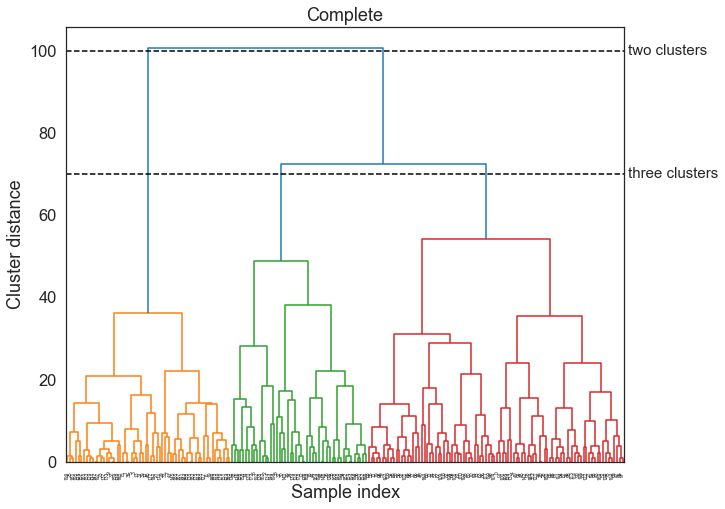

In [ ]:
linkage_array = complete(X)

plt.figure(figsize = (10, 8))
sns.set_style(style='white')

dendrogram(linkage_array, 25)
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [100, 100], '--', c='k')
ax.plot(bounds, [70, 70], '--', c='k')
ax.text(bounds[1], 100, ' two clusters', va='center', fontdict={'size': 15})
ax.text(bounds[1], 70, ' three clusters', va='center', fontdict={'size': 15})
plt.title('Complete')
plt.xlabel('Sample index')
plt.ylabel('Cluster distance');

**Posisi percabangan**
- 2 clusters = 100
- 3 clusters = 72
- 4 clusters = 53
- 5 clusters = 46

**Perubahan jarak**
- 2-3 = 28
- 3-4 = 19
- 4-5 = 7

**Hasil: 2 clusters paling optimal**

### **Average**

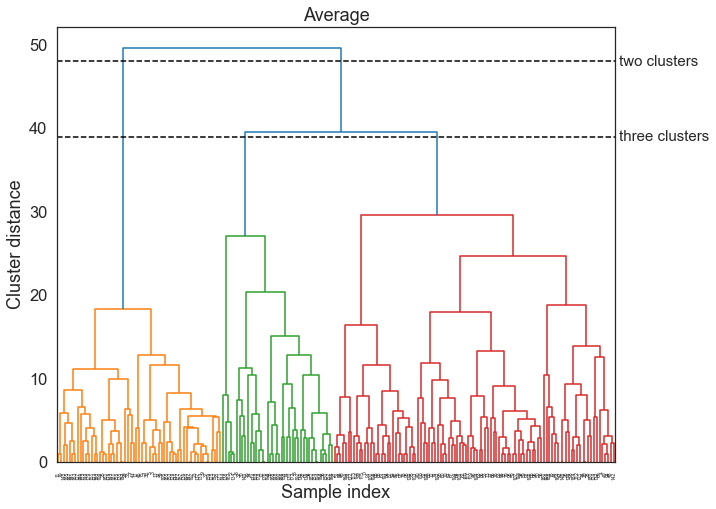

In [ ]:
linkage_array = average(X)

plt.figure(figsize = (10, 8))
sns.set_style(style='white')

dendrogram(linkage_array, 25)
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [48, 48], '--', c='k')
ax.plot(bounds, [39, 39], '--', c='k')
ax.text(bounds[1], 48, ' two clusters', va='center', fontdict={'size': 15})
ax.text(bounds[1], 39, ' three clusters', va='center', fontdict={'size': 15})
plt.title('Average')
plt.xlabel('Sample index')
plt.ylabel('Cluster distance');

**Posisi percabangan**
- 2 clusters = 50
- 3 clusters = 40
- 4 clusters = 29
- 5 clusters = 26

**Perubahan jarak**
- 2-3 = 10
- 3-4 = 11
- 4-5 = 3

**Hasil: 3 clusters paling optimal**

## **Results comparison**

**Pemilihan Jumlah Cluster**

- Pemilihan jumlah cluster pada agglomerative clustering dapat dipilih secara subjective (berdasarkan domain knowledge), atau dengan pendekatan memilih perubahan jarak terbesar. 

- Dari visualisasi dendrogram pada 3 metode di atas, kita mendapatkan kandidat metode dan cluster:
>- Ward: 2 cluster
>- Complete: 2 cluster
>- Average: 3 cluster

- Sekarang bisa kita bandingkan dan lihat sillhoutte score-nya antara 2 dan 3 clusters. Manakah metode dan berapa cluster-kah yang terbaik?

In [ ]:
# Comparison of 2 clusters

agg_ward = AgglomerativeClustering(n_clusters=2, linkage='ward')
df['Ward2'] = agg_ward.fit_predict(X_scaled)

agg_complete = AgglomerativeClustering(n_clusters=2, linkage='complete')
df['Complete2'] = agg_complete.fit_predict(X_scaled)

agg_average = AgglomerativeClustering(n_clusters=2, linkage='average')
df['Average2'] = agg_average.fit_predict(X_scaled)

df.head()

,Age,Annual Income,Spending Score,clusters,Ward2,Complete2,Average2
0,19,15,39,1,0,0,0
1,21,15,81,1,0,0,0
2,20,16,6,0,0,0,1
3,23,16,77,1,0,0,0
4,31,17,40,1,0,0,0


In [ ]:
print('Silhouette score ward 2 clusters:', silhouette_score(X_scaled, df['Ward2']))
print('Silhouette score complete 2 clusters:', silhouette_score(X_scaled, df['Complete2']))
print('Silhouette score average 2 clusters:', silhouette_score(X_scaled, df['Average2']))

Silhouette score ward 2 clusters: 0.41449964268735984
Silhouette score complete 2 clusters: 0.40413296730693504
Silhouette score average 2 clusters: 0.2512118533939994


In [ ]:
# Comparison of 3 clusters

agg_ward = AgglomerativeClustering(n_clusters=3, linkage='ward')
df['Ward3'] = agg_ward.fit_predict(X_scaled)

agg_complete = AgglomerativeClustering(n_clusters=3, linkage='complete')
df['Complete3'] = agg_complete.fit_predict(X_scaled)

agg_average = AgglomerativeClustering(n_clusters=3, linkage='average')
df['Average3'] = agg_average.fit_predict(X_scaled)

df.head()

,Age,Annual Income,Spending Score,clusters,Ward2,Complete2,Average2,Ward3,Complete3,Average3
0,19,15,39,1,0,0,0,1,0,2
1,21,15,81,1,0,0,0,2,2,2
2,20,16,6,0,0,0,1,1,0,1
3,23,16,77,1,0,0,0,2,2,2
4,31,17,40,1,0,0,0,1,0,2


In [ ]:
print('Silhouette score ward 3 clusters:', silhouette_score(X_scaled, df['Ward3']))
print('Silhouette score complete 3 clusters:', silhouette_score(X_scaled, df['Complete3']))
print('Silhouette score average 3 clusters:', silhouette_score(X_scaled, df['Average3']))

Silhouette score ward 3 clusters: 0.41664148520394606
Silhouette score complete 3 clusters: 0.40796901870628616
Silhouette score average 3 clusters: 0.41894341864426976


In [ ]:
pd.DataFrame({'Total Cluster': ['2 Clusters', '3 Clusters'],
    'Ward': [silhouette_score(X_scaled, df['Ward2']), silhouette_score(X_scaled, df['Ward3'])],
    'Complete': [silhouette_score(X_scaled, df['Complete2']), silhouette_score(X_scaled, df['Complete3'])],
    'Average': [silhouette_score(X_scaled, df['Average2']), silhouette_score(X_scaled, df['Average3'])]
})

,Total Cluster,Ward,Complete,Average
0,2 Clusters,0.414500,0.404133,0.251212
1,3 Clusters,0.416641,0.407969,0.418943


### **Interpretation**

Berdasarkan metode agglomerative clustering, didapat bahwa linkage average dengan jumlah 3 clusters adalah yang paling optimal untuk segmentasi customer pada case ini.

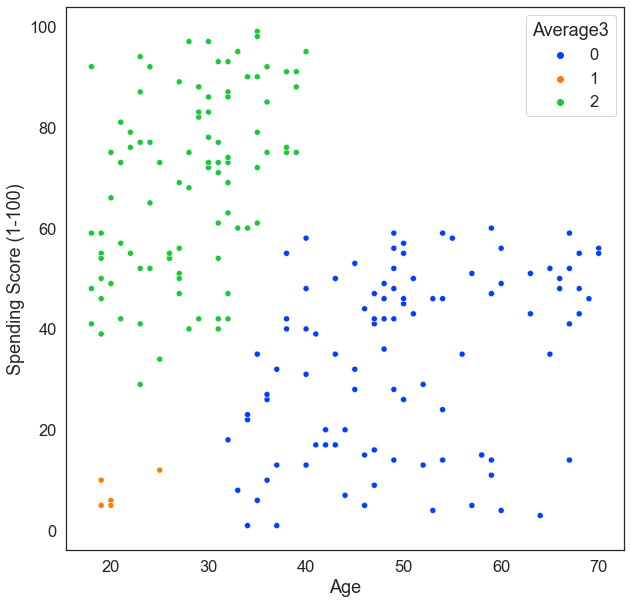

In [ ]:
# Plot Average
plt.figure(figsize = (10, 10))
sns.set_context(context = 'notebook', font_scale=1.5)
sns.scatterplot(
    x = 'Age', 
    y = 'Spending Score', 
    hue = 'Average3',
    data = df,
    palette='bright')

plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)');

## **DBScan**

**Optimizing epsilon & min_samples**

In [ ]:
for eps in [i/10 for i in range(1, 6)]:
    for min_sample in range(4, 8):
        print('\neps = {}'.format(eps))
        print(f'min_sample = {min_sample}')

        dbscan = DBSCAN(eps=eps, min_samples=min_sample)
        labels = dbscan.fit_predict(X_scaled)
        silhouette = silhouette_score(X_scaled, labels)
        
        print(f'cluster present: {np.unique(labels)}')
        print(f'cluster size: {np.bincount(labels+1)}')
        print(f'silhoutte score: {silhouette}')


eps = 0.1
min_sample = 4
cluster present: [-1  0  1]
cluster size: [188   8   4]
silhoutte score: -0.4124562023343181

eps = 0.1
min_sample = 5
cluster present: [-1  0]
cluster size: [192   8]
silhoutte score: -0.1172020347991878

eps = 0.1
min_sample = 6
cluster present: [-1  0]
cluster size: [192   8]
silhoutte score: -0.1172020347991878

eps = 0.1
min_sample = 7
cluster present: [-1  0]
cluster size: [192   8]
silhoutte score: -0.1172020347991878

eps = 0.2
min_sample = 4
cluster present: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12]
cluster size: [69  4  9  6 33  4  6 19  5 18 13  4  6  4]
silhoutte score: 0.08784364464505547

eps = 0.2
min_sample = 5
cluster present: [-1  0  1  2  3  4  5  6  7  8  9]
cluster size: [101   9  21   6  19   5   9   9  12   4   5]
silhoutte score: -0.03614408497663603

eps = 0.2
min_sample = 6
cluster present: [-1  0  1  2  3  4  5]
cluster size: [132   8  20  16   7   9   8]
silhoutte score: -0.11517918564675847

eps = 0.2
min_sample = 7
cluster prese

### **Interpretation**

Dari berbagai kombinasi epsilon dan min_samples, ada 2 pilihan terbaik yang dapat dipilih:
- eps = 0.5 & min_samples = 4, silhouette score 0.2512, 2 clusters, tidak ada noise.
- eps = 0.3 & min_samples = 4, silhouette score 0.2694, 7 clusters, terdapat noise.

Pada pilihan pertama, clustering data pada 2 cluster yang ada sangatlah timpang, sehingga hasil segmentasinya masih sangat general. 

Pada pilihan kedua, meskipun ada 9 noise, kemungkinan besar didapatkan hasil segmentasi customer yang lebih baik. Untuk dapat mengeceknya, kita dapat melihat pada scatter plot.

In [ ]:
# Fit DBScan
dbscan = DBSCAN(eps=0.3, min_samples=4)
clusters_dbs = dbscan.fit_predict(X_scaled)

print('cluster: \n',clusters_dbs)

cluster: 
 [ 0  0  1  0  0  0  2  0  3  0 -1  0  3  0  2  0  4  0  5  0  4  0  6  0
  3  0  4  0  4  0  3  0  3 -1  6  0  6  0  4  0  4  0  4  0  5  0  4  0
  0  0  4  0  0  4  4  4  4  4  0  4  4  0  4  4  4  0  4  4  0  0  4  4
  4  4  4  0  4  4  0  4  4 -1  4  4  0  4 -1  0  0  4  4  0  4  4  0  0
  4  0  4  0  0  4  4  0  4  0  4  4  4  4  4  0  4  0  0  0  4  4  4  4
  0  4 -1  0 -1  0  4  0  3  0  6  0 -1  0  1  0  6  0  1  0  3  0  0  0
 -1  0  4  0  4  0  6  0  6  0  6  0  2  0  2  0 -1  0  1  0  5  0  6  0
  4  0  6  0  2  0  3  0  3  0  3  0  4  0  6  0  4  0  5  0  6  0  4  0
  2  0  6  0  4  0  4  0]


In [ ]:
print('Silhouette score DBScan:', silhouette_score(X_scaled, clusters_dbs))

Silhouette score DBScan: 0.2694442574412798


In [ ]:
df['DBScan'] = dbscan.labels_
df.head(10)

,Age,Annual Income,Spending Score,clusters,Ward2,Complete2,Average2,Ward3,Complete3,Average3,DBScan
0,19,15,39,1,0,0,0,1,0,2,0
1,21,15,81,1,0,0,0,2,2,2,0
2,20,16,6,0,0,0,1,1,0,1,1
3,23,16,77,1,0,0,0,2,2,2,0
4,31,17,40,1,0,0,0,1,0,2,0
5,22,17,76,1,0,0,0,2,2,2,0
6,35,18,6,0,0,0,0,1,0,0,2
7,23,18,94,1,0,0,0,2,2,2,0
8,64,19,3,0,1,1,0,0,1,0,3
9,30,19,72,1,0,0,0,2,2,2,0


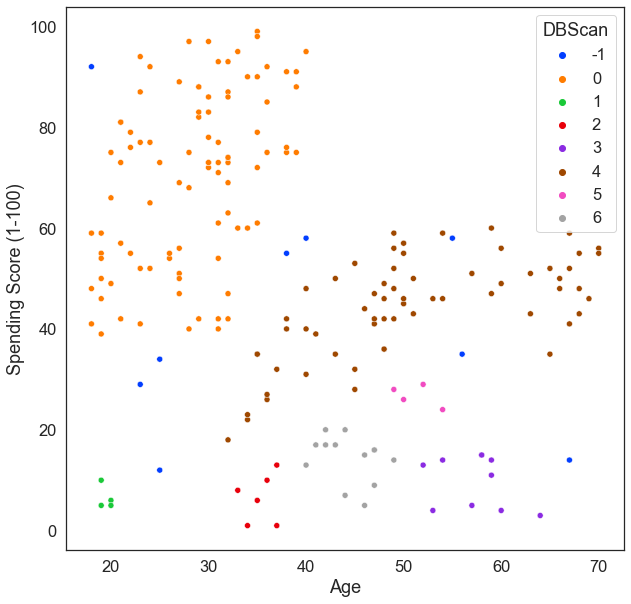

In [ ]:
# DBScan
plt.figure(figsize = (10, 10))
sns.set_context(context = 'notebook', font_scale=1.5)
sns.scatterplot(
    x = 'Age', 
    y = 'Spending Score', 
    hue = 'DBScan',
    data = df,
    palette='bright')

plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)');

## **Summary**

Dalam kasus segmentasi customer dengan menggunakan 2 features, yaitu 'Age' dan 'Spending Score', didapat bahwa metode K-Means menghasilkan hasil clustering yang paling optimal, jika ditinjau pada silhouette score yang didapat. Berdasarkan metode K-Means, customer hanya disegmentasikan ke dalam 2 cluster berbeda, yaitu:

1. Cluster customer berumur 18 hingga 40 tahun, yang mana spending score-nya bervariasi dari sekitar 25 hingga 99.

2. Cluster customer berumur 18 hingga 70 tahun dan spending score tertinggi hanya sekitar 60.

Dapat disimpulkan bahwa cluster pertama adalah cluster dengan customer dengan rentang umur remaja hingga dewasa yang lebih sering berbelanja atau melakukan transaksi di mall tersebut.